# Starting Simple: Flat to Matrix, only aggregate signal

In [2]:
import os

import pandas as pd
import numpy as np

import pyarrow.parquet as pq

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

import matplotlib.pyplot as plt


In [185]:
class ResstockDataset(Dataset):
    def __init__(self, basedir: str, filenames: list):
        self.basedir = basedir
        self.filenames = filenames
        self.filepaths = [os.path.join(basedir, filename) for filename in filenames]
        
        self.metadatas = [pq.read_metadata(p) for p in self.filepaths]
        
        self.lengths = [metadata.num_rows - 1 for metadata in self.metadatas]
        self.lengths_cumsum = np.cumsum(self.lengths)

        self.col_names = [c.name for c in self.metadatas[0].schema]
        
        self.total_length = sum(self.lengths)

        self.current_file_idx = None
        self.tables = {}
        
    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        file_idx = np.searchsorted(self.lengths_cumsum, idx)

        if file_idx == 0:
            row_idx = idx
        else:
            row_idx = idx - self.lengths_cumsum[file_idx-1]

        if file_idx != self.current_file_idx:
            self.current_file_idx = file_idx
            self.current_table = (
                pd.read_parquet(self.filepaths[file_idx])
                .values
                .astype(np.float32)
            )
        
        row = torch.from_numpy(self.current_table[row_idx, :])

        t = row[3:6] # time features
        
        h = torch.concat(
            (
                F.one_hot(row[6].long(), num_classes=49), # states one-hot
                F.one_hot(row[7].long(), num_classes=5), # building type one-hot
                row[8:13], # rest of house features
            ),
            dim=0
        )

        x = row[13:109] # aggregate load
        T = row[109:205] # temperature
        
        y = row[205:].reshape(-1, 96) # individual load profiles (11, 96)

        return t, h, x, T, y

class Flatten_input(torch.nn.Module):
    def forward(self, t, h, x, T):
        if t.ndim == 1:
            dim = 0
        else:
            dim = 1
        return torch.cat((t, h, x, T), dim=dim)

class SelectAggregateLoad(torch.nn.Module):
    def forward(self, t, h, x, T):
        return x

class UnFlatten_output(torch.nn.Module):
    def forward(self, x):
        if x.ndim == 1:
            return x.reshape(11, 96)
        elif x.ndim == 2:
            return x.reshape(-1, 11, 96)
        else:
            raise ValueError("Input tensor must be 1D or 2D")
        
class FlatModel(nn.Module):
    def __init__(self, hidden_size):
        super(FlatModel, self).__init__()
        self.flatten = SelectAggregateLoad()
        self.fc1 = nn.Linear(96, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, 11 * 96, bias=True)
        self.unflatten = UnFlatten_output()
    
    def forward(self, t, h, x, T):
        out = self.flatten(t, h, x, T)
        out = self.fc1(out)
        out = F.sigmoid(out)
        out = self.fc2(out)
        out = self.unflatten(out)
        return out

In [207]:
torch.manual_seed(42)
SEP = "-"*100
BASEDIR = '/Users/darwish/Documents/Berkeley_Offline/W210/capstone/data/resstock/staged/20240228131712'
TRAINING_FILES = ['partition=0.parquet', 'partition=1.parquet', 'partition=2.parquet', 'partition=3.parquet']
TEST_FILES = ['partition=4.parquet']

BATCH_SIZE = 73

hidden_size = 1000

num_epochs = 50
learning_rate = 0.01


train_dataset = ResstockDataset(BASEDIR, TRAINING_FILES)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = ResstockDataset(BASEDIR, TEST_FILES)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(SEP)
print('training size', len(train_dataset))
print('validation size', len(val_dataset))
print(SEP)

# Loss and optimizer
model = FlatModel(hidden_size)
print(SEP)
print(model)
print('number of parameters', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(SEP)
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

----------------------------------------------------------------------------------------------------
training size 14596
validation size 3649
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
FlatModel(
  (flatten): SelectAggregateLoad()
  (fc1): Linear(in_features=96, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1056, bias=True)
  (unflatten): UnFlatten_output()
)
number of parameters 1154056
----------------------------------------------------------------------------------------------------


In [208]:
# Train the model
losses = []
total_step = len(train_dataloader)
n_early_stop = len(train_dataloader)
eps_early_stop = 1e-6

for epoch in range(num_epochs):
    if epoch % 20 == 0:
        learning_rate = learning_rate / 10

    for i, (t, h, x, T, y) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(t, h, x, T)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        if (i+1) % 100 == 0:
            
            print(f"epoch {epoch+1}/{num_epochs}, step {i+1}/{total_step}, loss={loss.item()}")
        
        if epoch == 5:
            learning_rate = learning_rate / 10
    
    # early stopping (learning)
    if len(losses) > 2 * n_early_stop:
        delta_loss = abs(np.mean(losses[-n_early_stop:]) - np.mean(losses[-2 * n_early_stop:-n_early_stop]))
        print(f"delta loss: {delta_loss}")
        if delta_loss < eps_early_stop:
            print('early stopping')
            break

epoch 1/50, step 100/200, loss=0.03960329666733742
epoch 1/50, step 200/200, loss=0.026473291218280792
epoch 2/50, step 100/200, loss=0.010501544922590256
epoch 2/50, step 200/200, loss=0.014962123706936836
epoch 3/50, step 100/200, loss=0.0063744159415364265
epoch 3/50, step 200/200, loss=0.013194250874221325
delta loss: 0.004984597528818992
epoch 4/50, step 100/200, loss=0.005795380100607872
epoch 4/50, step 200/200, loss=0.012865416705608368
delta loss: 0.000777287349337713
epoch 5/50, step 100/200, loss=0.0057069603353738785
epoch 5/50, step 200/200, loss=0.012756886892020702
delta loss: 0.00017211365862749434
epoch 6/50, step 100/200, loss=0.005681258626282215
epoch 6/50, step 200/200, loss=0.01268533430993557
delta loss: 8.521607145667125e-05
epoch 7/50, step 100/200, loss=0.0056616757065057755
epoch 7/50, step 200/200, loss=0.012621528469026089
delta loss: 7.239908794872546e-05
epoch 8/50, step 100/200, loss=0.005642007105052471
epoch 8/50, step 200/200, loss=0.01256019528955221

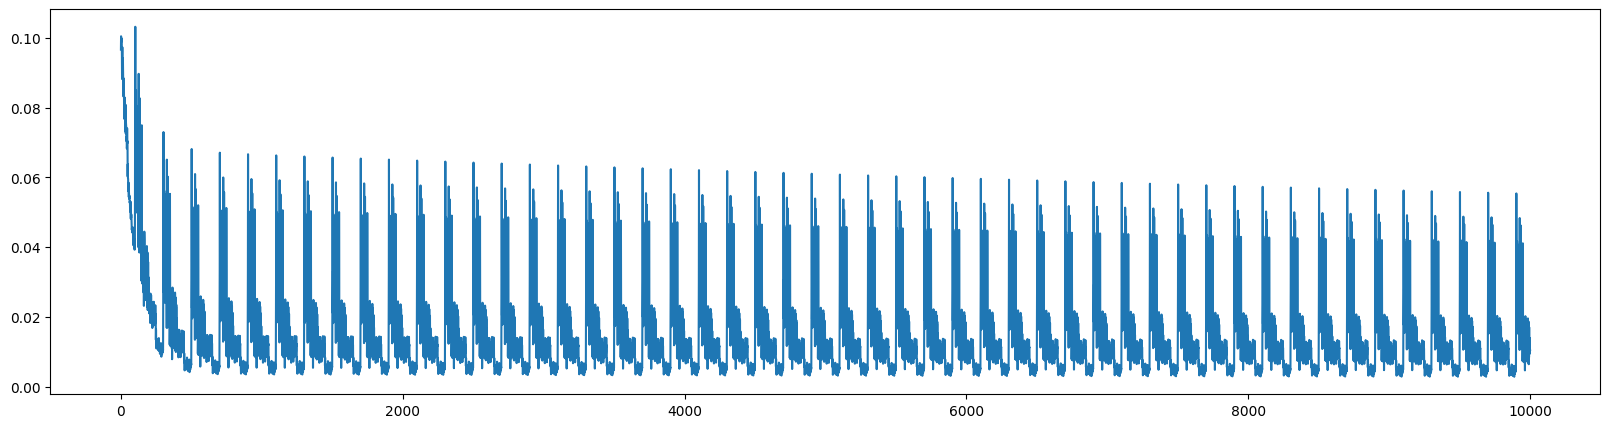

In [209]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.array(losses))

In [210]:
# why do these peaks happen?
np.array(losses).argmax()


102

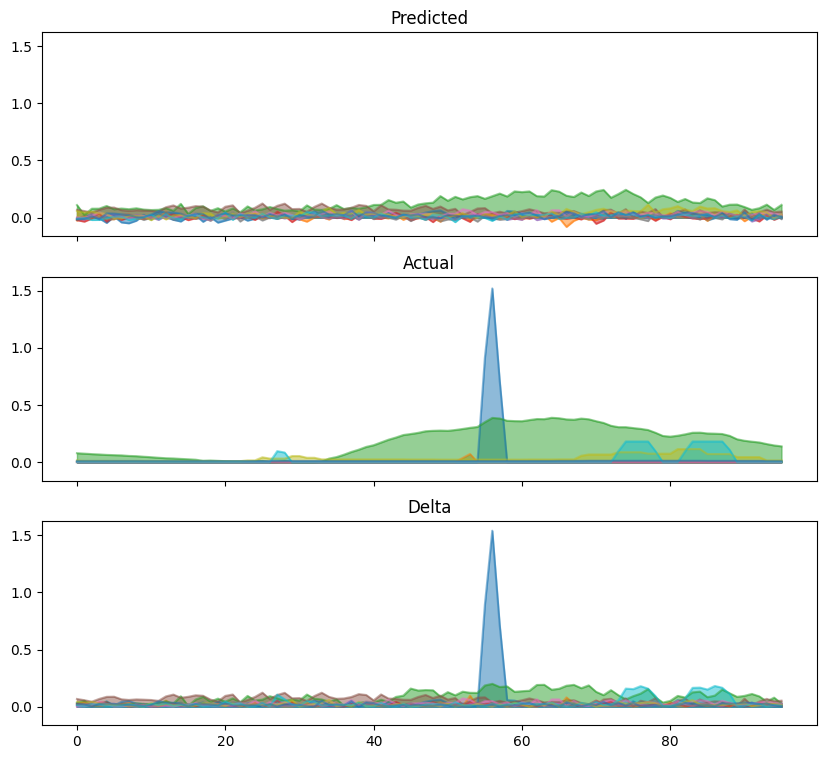

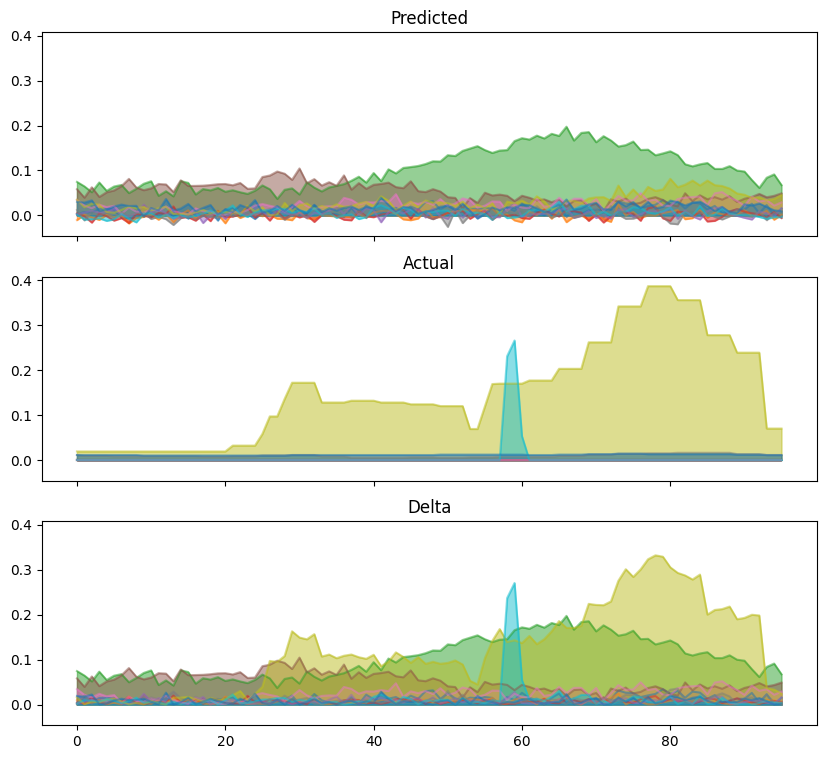

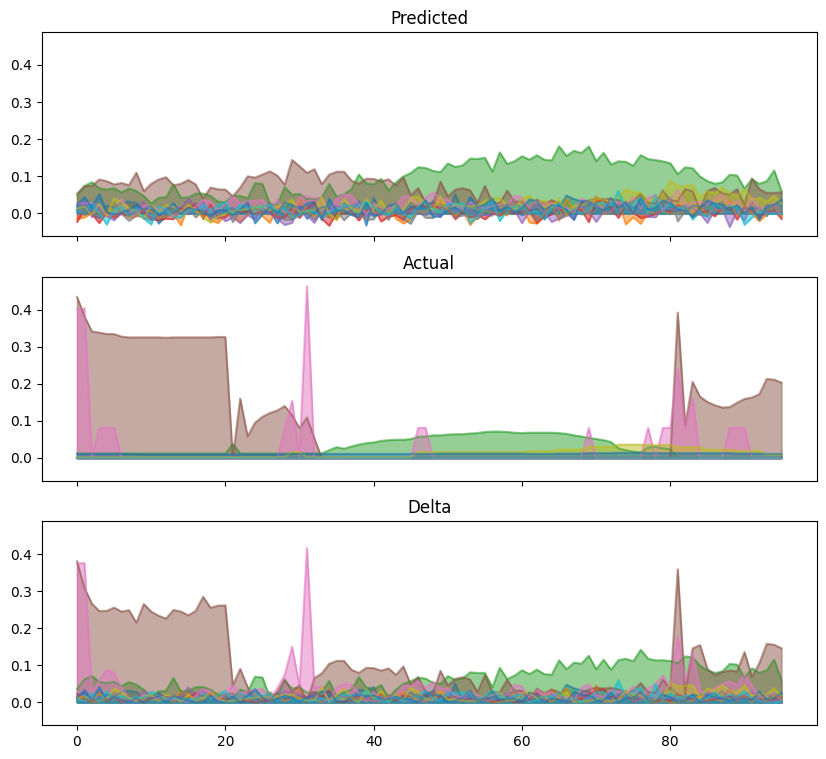

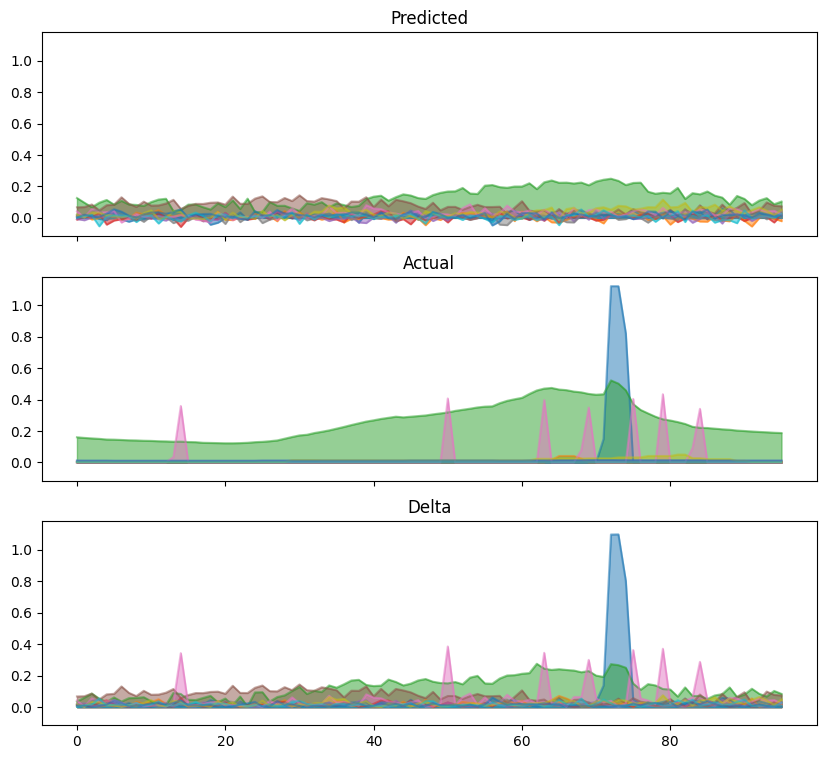

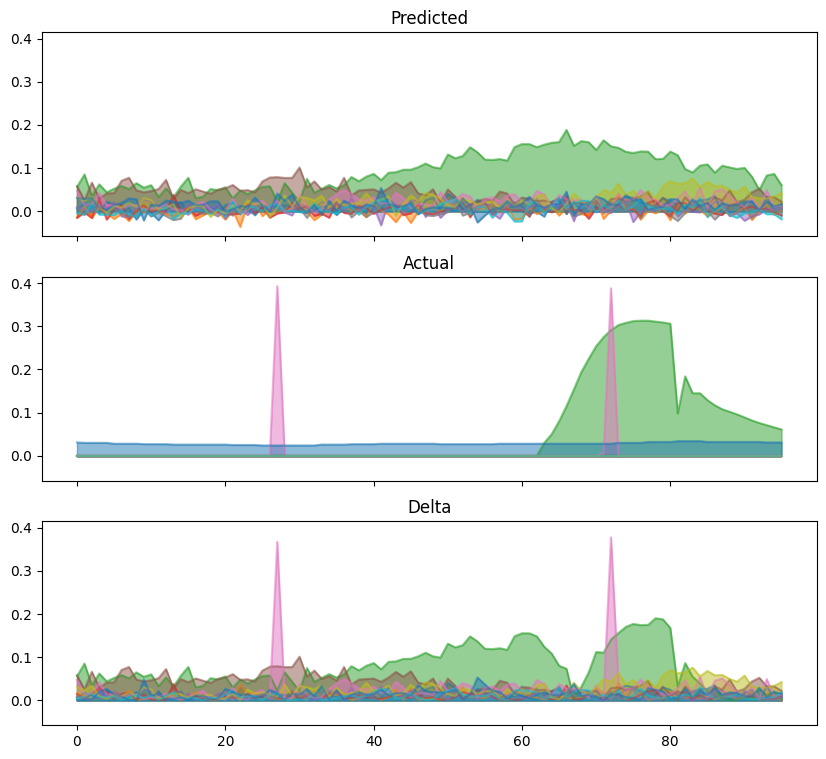

In [212]:
with torch.no_grad():
    # np.random.seed(42)
    for i in range(5):
        random_idx = np.random.randint(0, len(train_dataset))
        t, h, x, T, y = train_dataset[random_idx]

        preds = model(t, h, x, T).detach().numpy()
        y = y.detach().numpy()
        delta = np.abs(preds - y)

        fig, ax = plt.subplots(3, 1, figsize=(10, 9), sharex=True, sharey=True)
        # ax[0].imshow(preds)
        pd.DataFrame(preds.T).plot.area(legend=False, alpha=0.5, ax=ax[0], stacked=False)
        ax[0].set_title('Predicted')

        # ax[1].imshow(y)
        pd.DataFrame(y.T).plot.area(legend=False, alpha=0.5, ax=ax[1], stacked=False)
        ax[1].set_title('Actual')

        # ax[2].imshow(delta)
        pd.DataFrame(delta.T).plot.area(legend=False, alpha=0.5, ax=ax[2], stacked=False)
        ax[2].set_title('Delta')

        plt.show()

(array([ 57077., 119013., 119337., 119791., 118519., 118426., 119857.,
        118885., 118905.,  46190.]),
 array([-0.03522618, -0.02810689, -0.0209876 , -0.0138683 , -0.00674901,
         0.00037028,  0.00748957,  0.01460886,  0.02172815,  0.02884745,
         0.03596674]),
 <BarContainer object of 10 artists>)

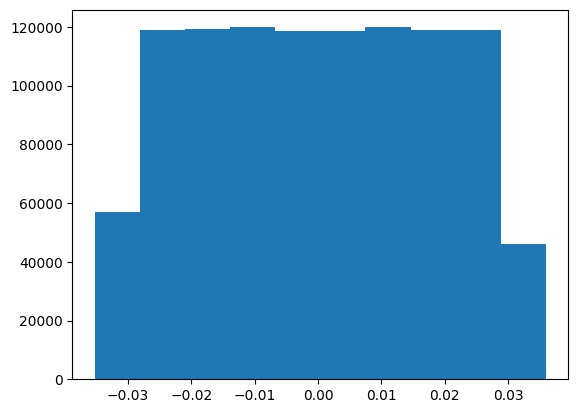

In [213]:
plt.hist(model.fc2.weight.detach().numpy().flatten())

In [184]:
# eval
with torch.no_grad():
    total_loss = 0
    for i, (t, h, x, T, y) in enumerate(val_dataloader):
        outputs = model(t, h, x, T)
        loss = criterion(outputs, y)
        total_loss += loss.item()
    print(f'Validation loss: {total_loss / len(val_dataloader)}')

    total_loss = 0
    for i, (t, h, x, T, y) in enumerate(train_dataloader):
        outputs = model(t, h, x, T)
        loss = criterion(outputs, y)
        total_loss += loss.item()
    print(f'Training loss: {total_loss / len(train_dataloader)}')

Validation loss: 0.021852240711450577
Training loss: 0.016896234769374133
